# LKJ Cholesky Covariance Priors for Multivariate Normal Models

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng()
az.style.use("arviz-darkgrid")

In [3]:
N = 10000

μ_actual = np.array([1.0, -2.0])
sigmas_actual = np.array([0.7, 1.5])
Rho_actual = np.matrix([[1.0, -0.4], [-0.4, 1.0]])

Σ_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

x = rng.multivariate_normal(μ_actual, Σ_actual, size=N)
Σ_actual

matrix([[ 0.49, -0.42],
        [-0.42,  2.25]])

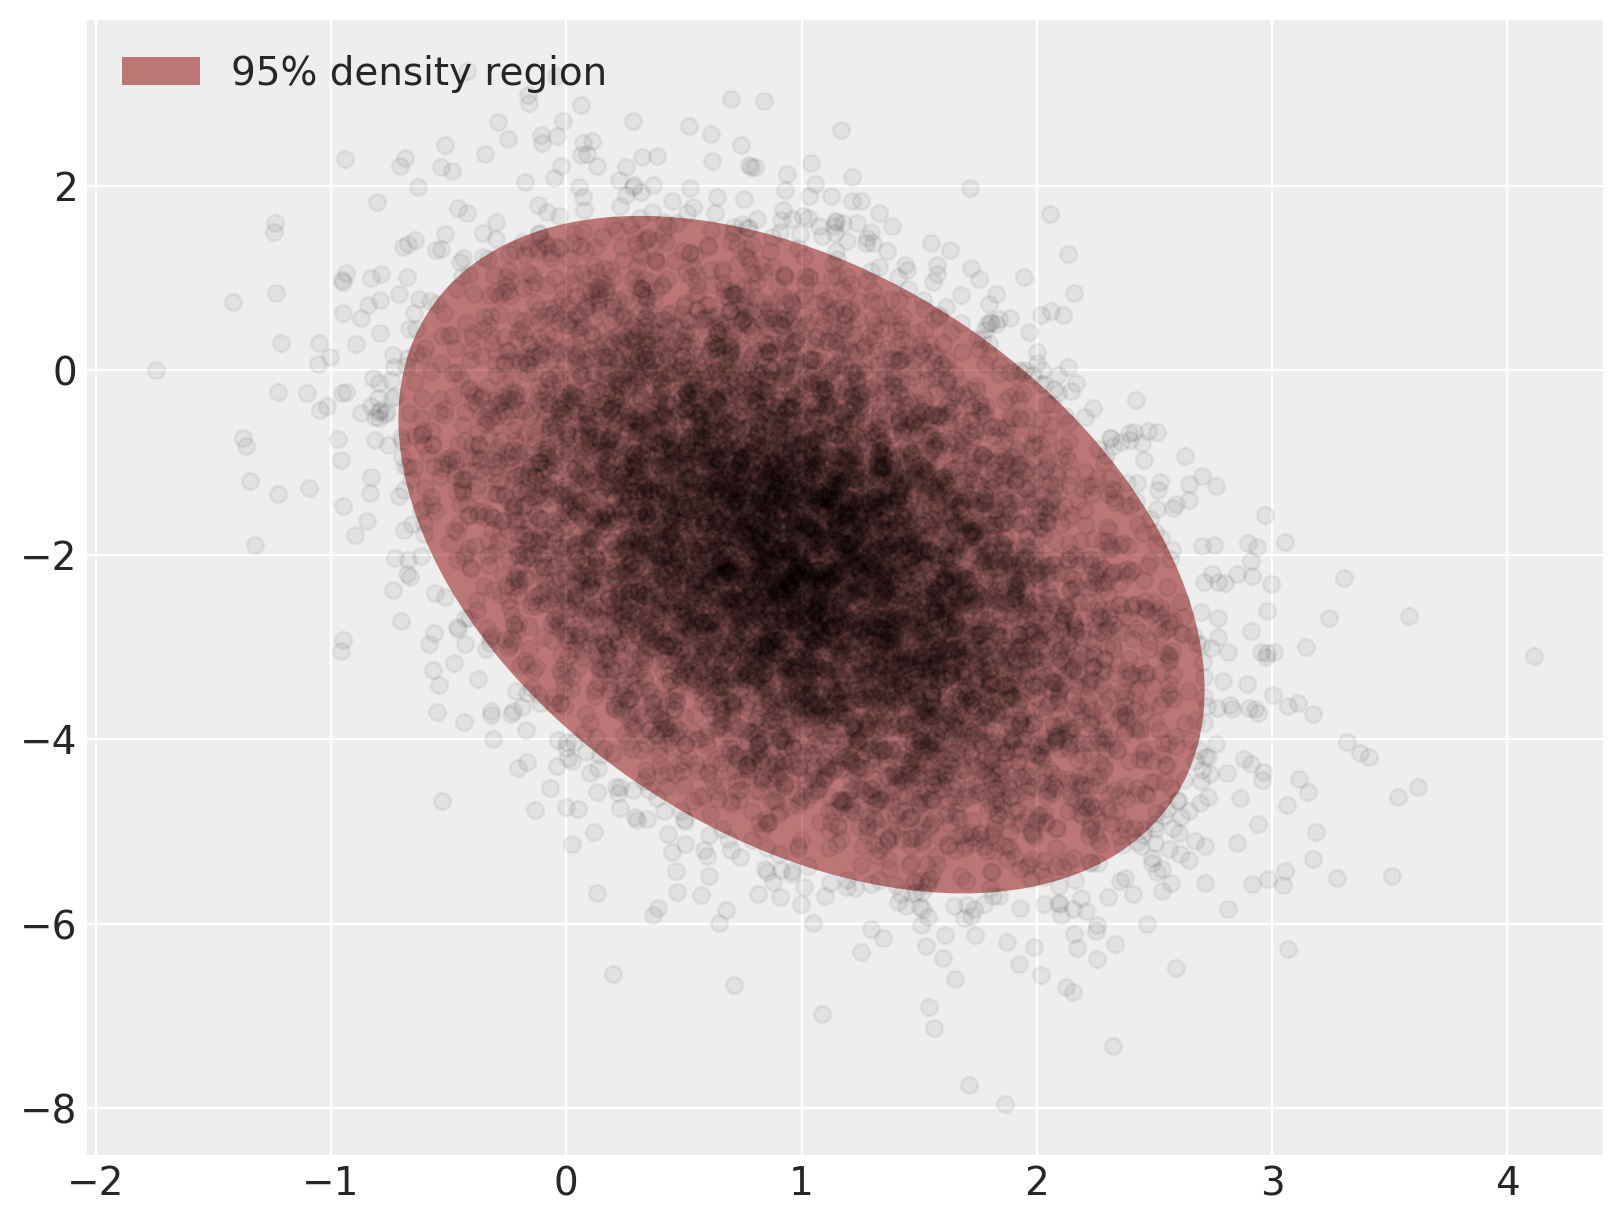

In [4]:
var, U = np.linalg.eig(Σ_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor("darkred")
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc="darkred", alpha=0.5)
ax.legend([rect], ["95% density region"], loc=2);

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$. The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$. Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix. This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](../api/distributions/multivariate.rst) distribution. This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC3 distribution of the component standard deviations, respectively. It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$. The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In this example, we model the standard deviations with $\textrm{Exponential}(1.0)$ priors, and the correlation matrix as $\mathbf{C} \sim \textrm{LKJ}(\eta = 2)$.

In [5]:
with pm.Model() as m:
    packed_L = pm.LKJCholeskyCov("packed_L", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0))

Since the Cholesky decompositon of $\Sigma$ is lower triangular, `LKJCholeskyCov` only stores the diagonal and sub-diagonal entries, for efficiency:

In [6]:
packed_L.tag.test_value.shape

(3,)

We use [expand_packed_triangular](../api/math.rst) to transform this vector into the lower triangular matrix $\mathbf{L}$, which appears in the Cholesky decomposition $\Sigma = \mathbf{L} \mathbf{L}^{\top}$.

In [7]:
with m:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = L.dot(L.T)

L.tag.test_value.shape

(2, 2)

Often however, you'll be interested in the posterior distribution of the correlations matrix and of the standard deviations, not in the posterior Cholesky covariance matrix *per se*. Why? Because the correlations and standard deviations are easier to interpret and often have a scientific meaning in the model. As of PyMC 3.9, there is a way to tell PyMC to automatically do these computations and store the posteriors in the trace. You just have to specify `compute_corr=True` in `pm.LKJCholeskyCov`:

In [8]:
with pm.Model(coords={"obs_id": np.arange(2)}) as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))

To complete our model, we place independent, weakly regularizing priors, $N(0, 1.5),$ on $\mu$:

In [9]:
with model:
    μ = pm.Normal("μ", 0.0, 1.5, testval=x.mean(axis=0), dims="obs_id")
    obs = pm.MvNormal("obs", μ, chol=chol, observed=x)

We sample from this model using NUTS and give the trace to [ArviZ](https://arviz-devs.github.io/arviz/):

In [10]:
with model:
    trace = pm.sample(random_seed=RANDOM_SEED, init="adapt_diag", return_inferencedata=True)
az.summary(trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],1.00,0.01,0.99,1.01,0.0,0.0,4563.32,3590.18,1.0
μ[1],-2.01,0.01,-2.04,-1.99,0.0,0.0,4716.04,3185.07,1.0
chol[0],0.69,0.00,0.68,0.70,0.0,0.0,5515.85,3247.18,1.0
chol[1],-0.59,0.01,-0.62,-0.56,0.0,0.0,5873.39,3208.26,1.0
chol[2],1.38,0.01,1.36,1.40,0.0,0.0,5394.28,3067.06,1.0
chol_stds[0],0.69,0.00,0.68,0.70,0.0,0.0,5515.85,3247.18,1.0
chol_stds[1],1.50,0.01,1.48,1.52,0.0,0.0,5160.65,3230.81,1.0
"chol_corr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN
"chol_corr[0,1]",-0.39,0.01,-0.41,-0.38,0.0,0.0,6175.31,3380.16,1.0
"chol_corr[1,0]",-0.39,0.01,-0.41,-0.38,0.0,0.0,6175.31,3380.16,1.0


Sampling went smoothly: no divergences and good r-hats. You can also see that the sampler recovered the true means, correlations and standard deviations. As often, that will be clearer in a graph:

/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/ada/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2

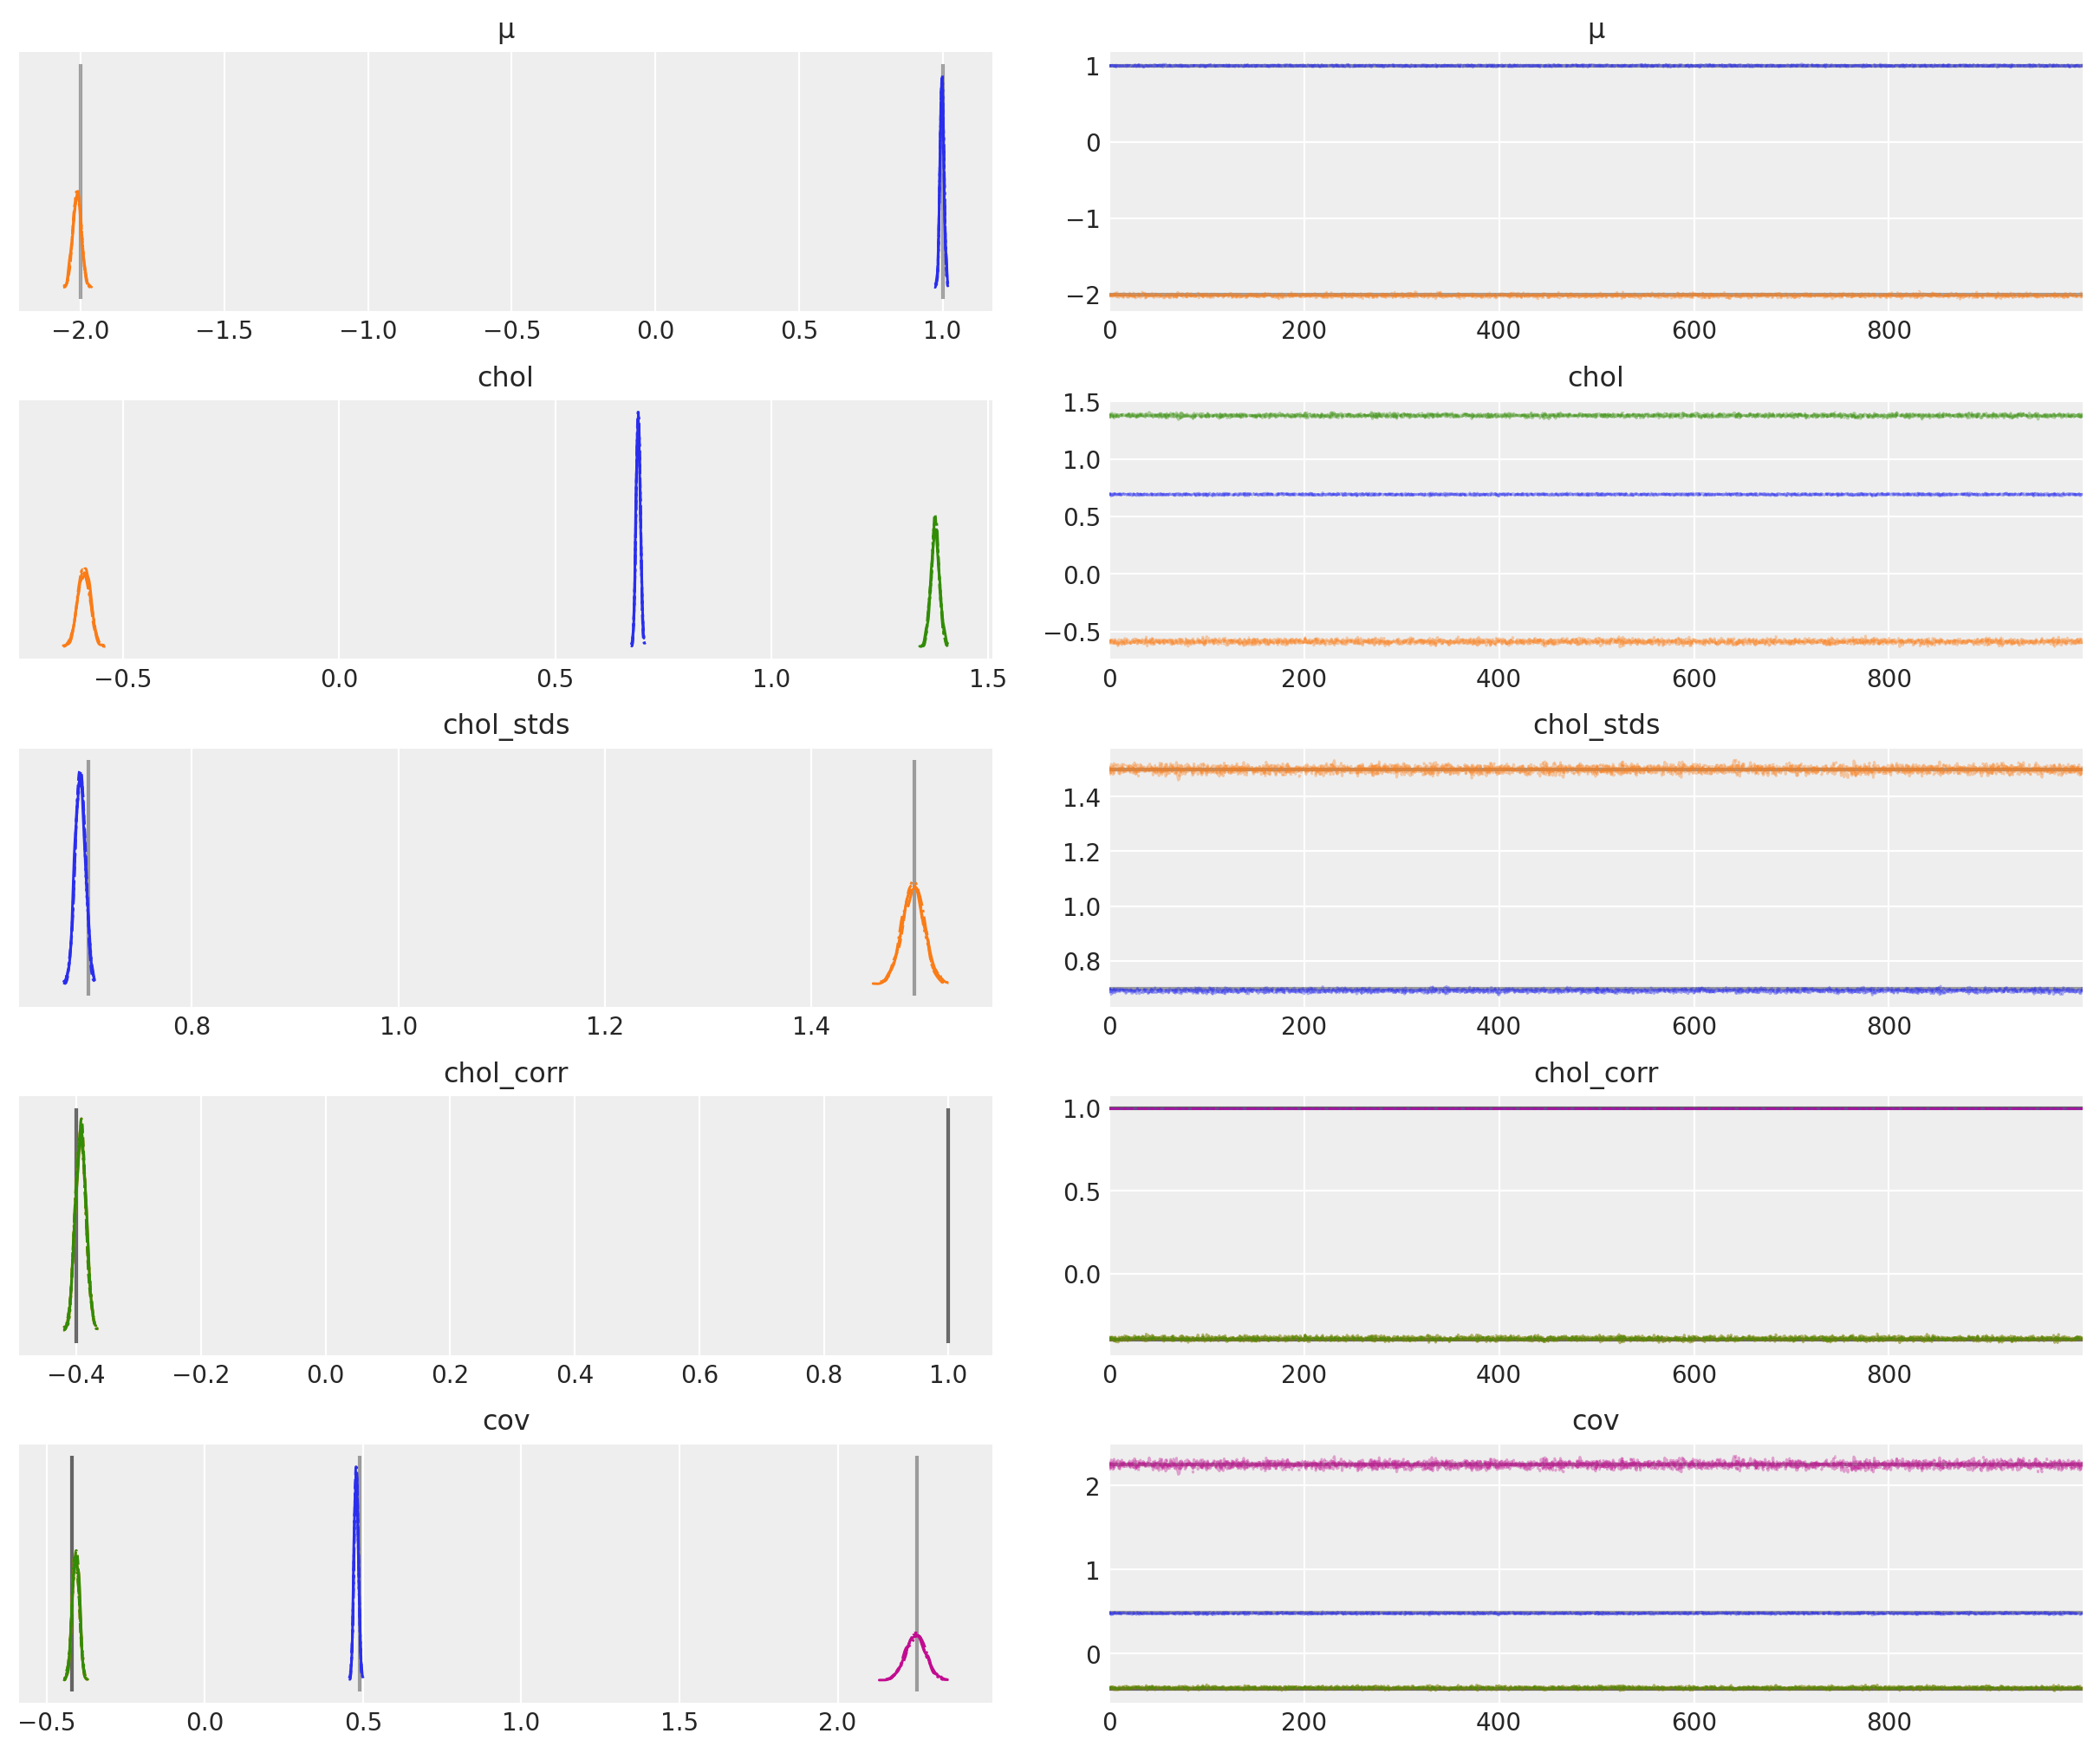

In [11]:
az.plot_trace(
    trace,
    compact=True,
    lines=[
        ("μ", {}, μ_actual),
        ("cov", {}, Σ_actual),
        ("chol_stds", {}, sigmas_actual),
        ("chol_corr", {}, Rho_actual),
    ],
);

The posterior expected values are very close to the true value of each component! How close exactly? Let's compute the percentage of closeness for $\mu$ and $\Sigma$:

In [12]:
μ_post = trace.posterior["μ"].mean(axis=(0, 1)).data
(1 - μ_post / μ_actual).round(2)

array([ 0.  , -0.01])

In [13]:
Σ_post = trace.posterior["cov"].mean(axis=(0, 1)).data
(1 - Σ_post / Σ_actual).round(2)

array([[0.02, 0.03],
       [0.03, 0.  ]])

So the posterior means are within 3% of the true values of $\mu$ and $\Sigma$.

Now let's replicate the plot we did at the beginning, but let's overlay the posterior distribution on top of the true distribution -- you'll see there is excellent visual agreement between both:

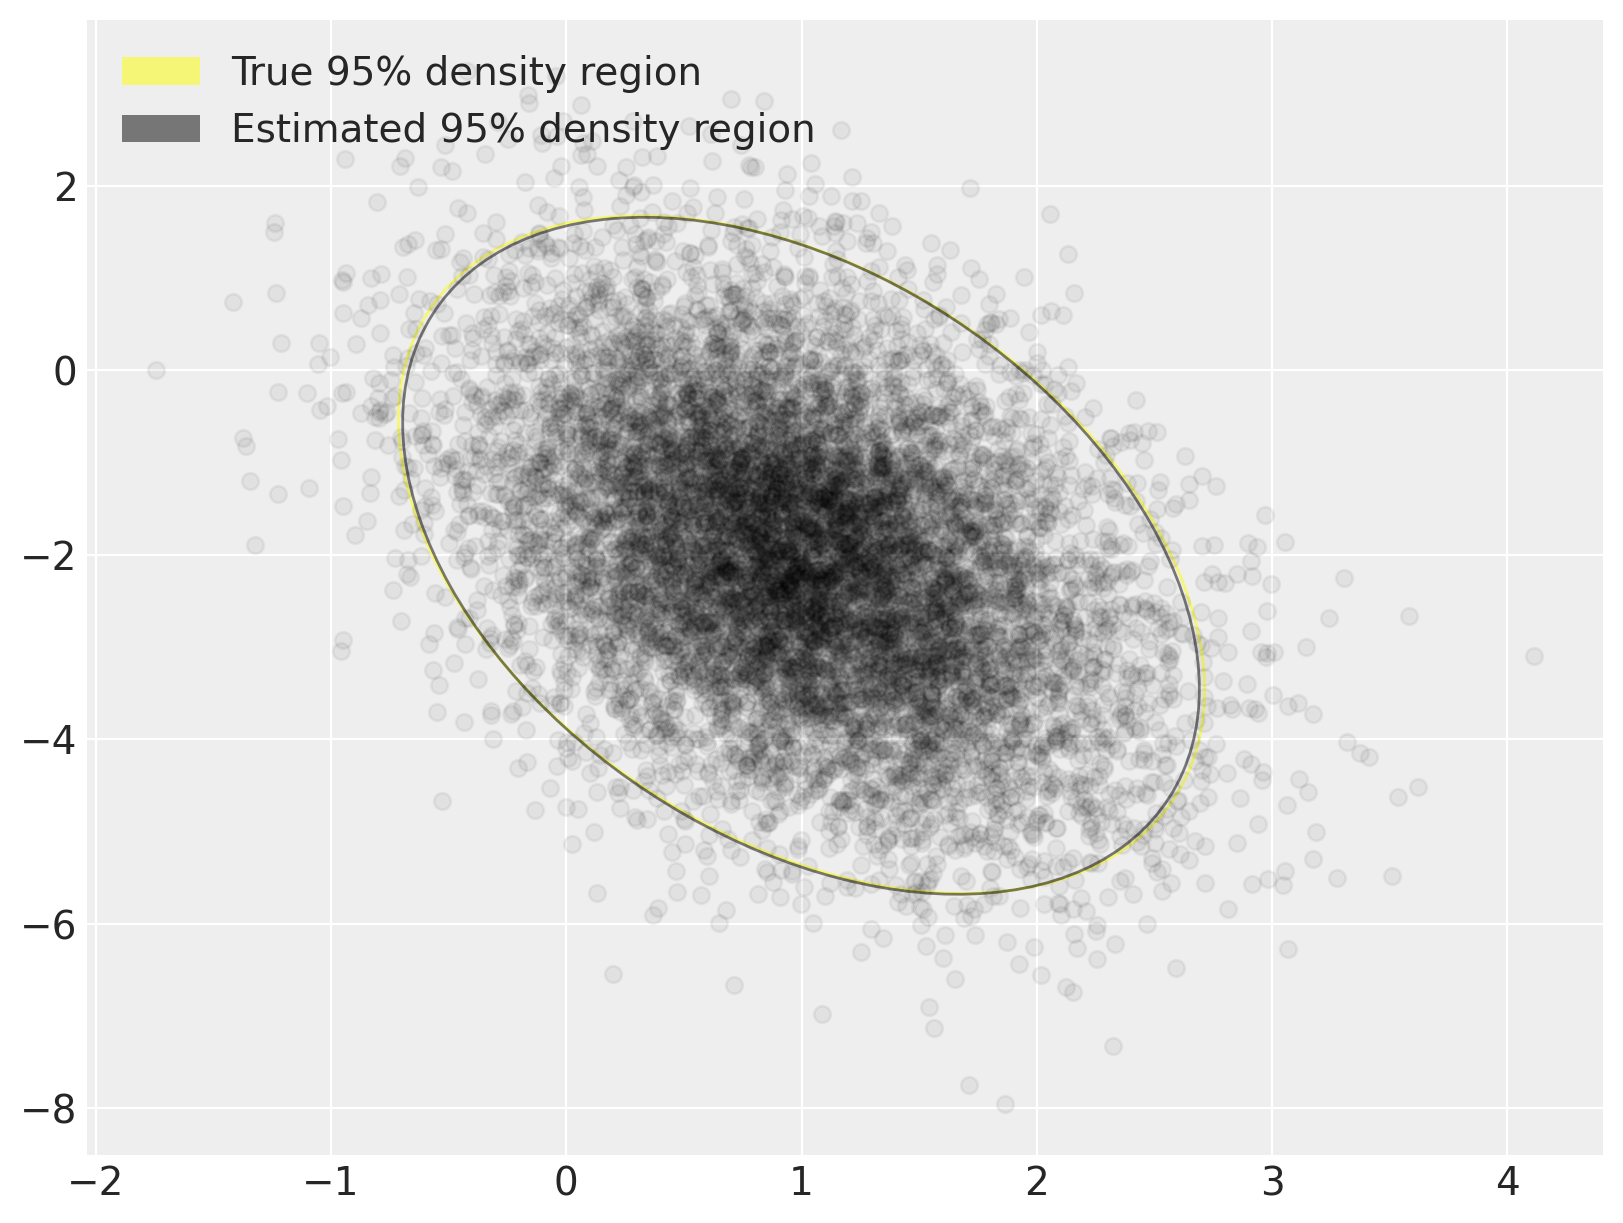

In [14]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180.0 / np.pi * np.arccos(np.abs(U_post[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_edgecolor("yellow")
e.set_zorder(10)
e.set_fill(False)
ax.add_artist(e)

e_post = Ellipse(
    μ_post,
    2 * np.sqrt(5.991 * var_post[0]),
    2 * np.sqrt(5.991 * var_post[1]),
    angle=angle_post,
)
e_post.set_alpha(0.5)
e_post.set_edgecolor("k")
e_post.set_zorder(10)
e_post.set_fill(False)
ax.add_artist(e_post)

ax.scatter(x[:, 0], x[:, 1], c="k", alpha=0.05, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc="yellow", alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc="k", alpha=0.5)
ax.legend(
    [rect, rect_post],
    ["True 95% density region", "Estimated 95% density region"],
    loc=2,
);

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Thu Aug 12 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

theano: 1.1.2
xarray: 0.17.0

matplotlib: 3.3.4
numpy     : 1.21.0
seaborn   : 0.11.1
arviz     : 0.11.2
pymc3     : 3.11.2

Watermark: 2.2.0

